In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# method
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.utils import resample

In [ ]:
# matplotlib 한글 폰트 셋업
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
# %config InlineBackend.figure_format = 'retina'
# !apt-get update && apt -qq -y install fonts-nanum 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fm.fontManager.addfont(fontpath)  # 에전의 rebuild 대신 이걸 추가해야 설치한 폰트 추가됨
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)  # Glyph 8722 방지용

In [3]:
countries = ['CN', 'US', 'VN', 'JP', 'HK', 'AU', 'TW', 'IN', 'SG', 'MX']
country_names = ["중국", "미국", "베트남", "일본", "홍콩", "대만", "싱가포르", "인도", "호주", "멕시코"]

### 1. 예측 대상 선정

- 2022년 기준 수출 top10 국가의 hs4 기준 국가별 수출 품목 top5
- 총 10*5 = 50개 품목(중복 포함됨)
- 수출 품목은 2013~2022의 10년간 수출액수 합계 기준 상위 5개 품목임

In [41]:
# 국가별 HS4 기준으로 top10 모으기
top_n = 10

dfs = []
for country in tqdm(countries):
    # 데이터 로드
    df = pd.read_csv(f"../DATA/수출입_국가별({country})_All.csv", low_memory=False)
    df = df.loc[df["HS코드"] != "-", :]
    
    # 2018~2022 5년간
    df = df.loc[df["year"] >= 2013, :]
    df = df.loc[df["year"] <= 2022, :]
    df["HS4"] = df["HS코드"].str[:4]
    df["ym"] = df["기간"].apply(lambda x: int(x.replace(".", "")))
    
    # 상위 top_n개 품목 추출
    hs4_top = df.groupby("HS4")["수출금액(달러)"].sum().sort_values(ascending=False) / 10   # 5년 평균
    temp = pd.DataFrame(index=range(1, top_n + 1))
    temp[f"{country}_HS4"] = hs4_top.index[:top_n]
    temp[f"{country}_HS4_수출"] = hs4_top.values[:top_n] / 1_000_000_000  # 10억 달러 (러프하게 n조 원 쯤으로 계산 가능하게)
    
    dfs.append(temp)


df_hs4 = pd.concat(dfs, axis=1)

100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


In [44]:
# 이름 매핑한 결과물 저장
df_hs4.to_csv("./output_3.2/국가별_hs4_top10.csv")
df_hs4

,CN_HS4,CN_HS4_수출,US_HS4,US_HS4_수출,VN_HS4,VN_HS4_수출,JP_HS4,JP_HS4_수출,HK_HS4,HK_HS4_수출,AU_HS4,AU_HS4_수출,TW_HS4,TW_HS4_수출,IN_HS4,IN_HS4_수출,SG_HS4,SG_HS4_수출,MX_HS4,MX_HS4_수출
1,8542,33.086821,8703,15.912189,8542,7.891210,2710,4.424273,8542,18.498919,2710,4.130315,8542,5.498200,8708,0.902773,2710,5.330197,8708,1.128181
2,9013,9.763342,8708,5.637777,8517,4.786295,8542,0.942104,8517,1.676779,8703,2.085012,2710,2.190534,8542,0.875342,8542,3.535930,8529,0.830031
3,2902,6.666866,8517,5.171035,2710,1.480758,8517,0.865383,8473,1.339721,8905,1.165380,2902,1.052941,8517,0.681362,8901,2.165954,9013,0.754376
4,2710,5.475056,8473,3.771944,8529,1.410690,7106,0.840912,2710,1.170303,7308,0.276069,8486,0.557690,2710,0.680076,8905,0.330502,7210,0.642241
5,8486,3.874819,2710,3.608693,8534,1.387871,7208,0.731165,8901,0.785728,8708,0.138090,8534,0.459813,7208,0.631068,8486,0.322784,8703,0.435470
6,8517,3.490074,8523,1.771495,8524,1.224188,8708,0.638661,8523,0.676733,8507,0.134132,2707,0.194638,7210,0.354872,8473,0.198018,7209,0.279874
7,8708,3.144597,8418,1.434489,8548,0.899998,7210,0.462158,3304,0.649241,2815,0.113229,3818,0.165836,7225,0.333463,8409,0.161746,7208,0.240370
8,8529,2.954993,8507,1.301470,9013,0.879191,8541,0.410714,8541,0.394032,8528,0.105908,8473,0.163576,3904,0.288223,7108,0.133552,8905,0.215876
9,8473,2.444070,4011,1.244024,8479,0.758104,8486,0.393921,9013,0.368641,7210,0.105358,2901,0.151403,2917,0.281486,8523,0.104853,3903,0.204852
10,2901,2.356521,7306,1.065604,8541,0.664192,7209,0.376278,7108,0.359137,4810,0.086794,8523,0.147700,7901,0.266785,8517,0.101450,8409,0.184467


In [58]:
# 중간 결과물 저장
HS4_replace_dict = {'2601':'철광', 
'2701':'연탄,조개탄', '2709':'석유,역청유', '2710':'석유,역청유', '2711':'석유가스, 탄화수소',
'2841':'산화금속산염, 과산화금속산염',
'2902':'환식탄화수소',
'2601':'철광',
'7106' : '은',
'7208' : '비도금 강판(포일)', '7210' : '도금 강판(포일)',
'7308' : '철강 구조물',
'8471':'비전기식 공업용 노, 오븐', '8473':'보일러 부속품', '8486' : '반도체, 전자직접회로',
'8507':'축전지', '8517':'전화기', '8523':'디스크,스마트 카드', '8529':'전자기기 부속품', 
'8524' : '평판디스플레이 모듈', '8542':'전자집적회로','8534':'인쇄회로',
'8703':'승용차', '8708':'차량 부속품',
'8901':'순항선,유람선,화물선', '8905':'특수 선박',
'9013':'레이저기기'}

def func(x):
    if x in HS4_replace_dict:
        return f"{HS4_replace_dict[x]}({x})"
    else:
        return x

temp = df_hs4.copy()

for i in temp.index:
    temp.loc[i] = temp.loc[i].apply(func)

temp.to_csv("./output_3.2/국가별_hs4_kor_top10.csv")
temp

,CN_HS4,CN_HS4_수출,US_HS4,US_HS4_수출,VN_HS4,VN_HS4_수출,JP_HS4,JP_HS4_수출,HK_HS4,HK_HS4_수출,AU_HS4,AU_HS4_수출,TW_HS4,TW_HS4_수출,IN_HS4,IN_HS4_수출,SG_HS4,SG_HS4_수출,MX_HS4,MX_HS4_수출
1,전자집적회로(8542),33.086821,승용차(8703),15.912189,전자집적회로(8542),7.891210,"석유,역청유(2710)",4.424273,전자집적회로(8542),18.498919,"석유,역청유(2710)",4.130315,전자집적회로(8542),5.498200,차량 부속품(8708),0.902773,"석유,역청유(2710)",5.330197,차량 부속품(8708),1.128181
2,레이저기기(9013),9.763342,차량 부속품(8708),5.637777,전화기(8517),4.786295,전자집적회로(8542),0.942104,전화기(8517),1.676779,승용차(8703),2.085012,"석유,역청유(2710)",2.190534,전자집적회로(8542),0.875342,전자집적회로(8542),3.535930,전자기기 부속품(8529),0.830031
3,환식탄화수소(2902),6.666866,전화기(8517),5.171035,"석유,역청유(2710)",1.480758,전화기(8517),0.865383,보일러 부속품(8473),1.339721,특수 선박(8905),1.165380,환식탄화수소(2902),1.052941,전화기(8517),0.681362,"순항선,유람선,화물선(8901)",2.165954,레이저기기(9013),0.754376
4,"석유,역청유(2710)",5.475056,보일러 부속품(8473),3.771944,전자기기 부속품(8529),1.410690,은(7106),0.840912,"석유,역청유(2710)",1.170303,철강 구조물(7308),0.276069,"반도체, 전자직접회로(8486)",0.557690,"석유,역청유(2710)",0.680076,특수 선박(8905),0.330502,도금 강판(포일)(7210),0.642241
5,"반도체, 전자직접회로(8486)",3.874819,"석유,역청유(2710)",3.608693,인쇄회로(8534),1.387871,비도금 강판(포일)(7208),0.731165,"순항선,유람선,화물선(8901)",0.785728,차량 부속품(8708),0.138090,인쇄회로(8534),0.459813,비도금 강판(포일)(7208),0.631068,"반도체, 전자직접회로(8486)",0.322784,승용차(8703),0.435470
6,전화기(8517),3.490074,"디스크,스마트 카드(8523)",1.771495,평판디스플레이 모듈(8524),1.224188,차량 부속품(8708),0.638661,"디스크,스마트 카드(8523)",0.676733,축전지(8507),0.134132,2707,0.194638,도금 강판(포일)(7210),0.354872,보일러 부속품(8473),0.198018,7209,0.279874
7,차량 부속품(8708),3.144597,8418,1.434489,8548,0.899998,도금 강판(포일)(7210),0.462158,3304,0.649241,2815,0.113229,3818,0.165836,7225,0.333463,8409,0.161746,비도금 강판(포일)(7208),0.240370
8,전자기기 부속품(8529),2.954993,축전지(8507),1.301470,레이저기기(9013),0.879191,8541,0.410714,8541,0.394032,8528,0.105908,보일러 부속품(8473),0.163576,3904,0.288223,7108,0.133552,특수 선박(8905),0.215876
9,보일러 부속품(8473),2.444070,4011,1.244024,8479,0.758104,"반도체, 전자직접회로(8486)",0.393921,레이저기기(9013),0.368641,도금 강판(포일)(7210),0.105358,2901,0.151403,2917,0.281486,"디스크,스마트 카드(8523)",0.104853,3903,0.204852
10,2901,2.356521,7306,1.065604,8541,0.664192,7209,0.376278,7108,0.359137,4810,0.086794,"디스크,스마트 카드(8523)",0.147700,7901,0.266785,전화기(8517),0.101450,8409,0.184467


In [31]:
# 국가별 top5 HS4만 데이터프레임으로 정리
top5 = 5
hs4_top5 = pd.DataFrame(index=range(1, top5 + 1))

for country in countries:
    hs4_top5[country] = df_hs4[f"{country}_HS4"].iloc[:top5]

hs4_top5

,CN,US,VN,JP,HK,AU,TW,IN,SG,MX
1,8542,8703,8542,2710,8542,2710,8542,8708,2710,8708
2,9013,8708,8517,8542,8517,8703,2710,8542,8542,8529
3,2902,8517,2710,8517,8473,8905,2902,8517,8901,9013
4,2710,8473,8529,7106,2710,7308,8486,2710,8905,7210
5,8486,2710,8534,7208,8901,8708,8534,7208,8486,8703


In [32]:
# hs4_top5의 중복 없는 코드 목록
unique_hs4_top5 = np.unique(hs4_top5.values.flatten()).tolist()  # 2d를 1a로
print(len(unique_hs4_top5))
print(unique_hs4_top5)

17
['2710', '2902', '7106', '7208', '7210', '7308', '8473', '8486', '8517', '8529', '8534', '8542', '8703', '8708', '8901', '8905', '9013']


### 2. 자기회귀모형

- 총 50개 (top10국가 * 국가별 hs4 top5)

In [34]:
# predict하기 위해 사용할 데이터
split_date = "2022.01"  # 23년만을 pred로 

# MEMO: 2021년부터 split한 것은, 2022년 부터는 전체 다 감소한(0인) 품목이 있어서 이 경우 ROC_AUC_SCore가 계산 불가능하여, 기간을 1년 더 추가함

In [35]:
### 전체 반복문 ###
for country in tqdm(countries):
    ### 국가별 데이터 로딩 ###
    # data load
    df = pd.read_csv(f"../DATA/수출입_국가별({country})_All.csv", low_memory=False)
    df = df.loc[df["HS코드"] != "-", :].copy()
    df["HS4"] = df["HS코드"].str[:4]

    tables = []

    for code in hs4_top5[country]:
        ### 데이터 처리 ###
        # HS코드기준 필터 해서 데이터 처리
        temp_df = df.loc[df["HS4"] == code, :].copy()
        monthly_sum = temp_df.groupby("기간")["수출금액(달러)"].sum()
        # print(monthly_sum)
        
        # inf 변화율 방지를 위한 1달러 추가 (0원 방지)
        monthly_sum += 1

        # yoy
        data = pd.DataFrame(data=monthly_sum)
        data["yoy"] = monthly_sum.pct_change(12) * 100
        # yoy time_lag
        for lag in range(1, 12 + 1):
            data[f"yoy_t{lag}"] = data["yoy"].shift(lag)
        # yoy_bin
        func = lambda x: 0 if x < 0 else 1
        data["yoy_bin"] = data["yoy"].dropna().apply(func)

        # save
        data.to_csv(f"./output_3.2/AR모형_데이터/YoYData_{country}_{code}.csv")
        
        if len(data.dropna()) == 0:
            print("데이터가 부족함:", country, code, len(data))
            continue

        ### 모델 적합 ###

        temp = data.dropna().copy()
        temp["yoy_bin"] = temp["yoy_bin"].astype(int)
        X = temp.drop(["수출금액(달러)", "yoy", "yoy_bin"], axis=1).copy()
        y = temp["yoy_bin"].copy()
        
        # 훈련, 평가 시 사용할
        X_run = X.loc[:split_date].iloc[:-1]
        y_run = y.loc[:split_date].iloc[:-1]
        
        # predict 만들 때 사용할
        X_predict = X.loc[split_date:]  # split_date부터 끝까지 포함
        y_predict = y.loc[split_date:]
        

        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_run, y_run, test_size=0.2, random_state=0)

        model = DecisionTreeClassifier(max_depth=4)
        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # importance
        imp = model.feature_importances_
        features = X_train.columns

        fimp = pd.DataFrame(data=imp, index=features, columns=["importance"])
        fimp = fimp.sort_values("importance", ascending=False)

        # scoring
        acc = accuracy_score(y_test, y_pred)
        vc = y_test.value_counts()
        if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
            auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:  # else: ROC_AUC 계산 불가함
            auc = None
        # auc = roc_auc_score(y_test, y_pred_proba[:, 1])

        table = fimp.loc[[f"yoy_t{n_lag}" for n_lag in range(1, 12 + 1)]].copy()
        table.columns = [f"{country}_{code}",]
        table = table.T
        table["N_Train"] = len(X_train)
        table["N_Test"] = len(X_test)
        table["accuracy"] = acc
        table["roc_auc"] = auc

        tables.append(table)

        # Tree 그래프
        fig = plt.figure(figsize=(15, 8))
        # tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=["0", "1"])
        tree.plot_tree(model, filled=True, feature_names=X_train.columns, class_names=y_train.astype(str).unique())
        plt.title(f'{country}_{code} Tree')
        plt.savefig(f"./output_3.2/AR모형_Plot/TreeVis_{country}_{code}.png", dpi=300)  # 저장 시 항상 DPI는 300
        plt.close(fig)  # 저장한 plot은 close
        plt.close()

        # importance plot
        fig = plt.figure(figsize=(15, 8))
        fimp.plot.bar(color='#B4C6E7')
        plt.title(f'{country}_{code} Feature Importances')
        plt.grid(True)
        plt.savefig(f"./output_3.2/AR모형_Plot/FImp_{country}_{code}.png", dpi=300)  # 저장 시 항상 DPI는 300
        plt.close(fig)  # 저장한 plot은 close
        plt.close()
        
        if len(X_predict.dropna()) == 0:
            print("데이터가 부족함(Predict):", country, code, len(data))
            continue

        # 예측값도 저장 (추론모형에 포함)
        model_pred = pd.DataFrame(y_predict)
        model_pred.columns = ["True"]
        model_pred["Predict"] = model.predict(X_predict)
        model_pred["Proba"] = model.predict_proba(X_predict)[:, 1]
        model_pred.to_csv(f"./output_3.2/AR모형_데이터/Predict_{country}_{code}.csv")
            
    result_random = pd.concat(tables)
    result_random.to_csv(f"./output_3.2/AR모형_데이터/ARTable_{country}.csv")

    
### 실행하고 나서 output 날리기 ###

 50%|█████     | 5/10 [01:12<01:09, 13.81s/it]

데이터가 부족함: AU 8905 14


 80%|████████  | 8/10 [01:45<00:24, 12.09s/it]

데이터가 부족함(Predict): SG 8905 54


100%|██████████| 10/10 [02:08<00:00, 12.85s/it]


In [36]:
X_run

,yoy_t1,yoy_t2,yoy_t3,yoy_t4,yoy_t5,yoy_t6,yoy_t7,yoy_t8,yoy_t9,yoy_t10,yoy_t11,yoy_t12
기간,,,,,,,,,,,,
2000.05,-99.997398,-99.957841,-99.960846,-99.982524,0.000000,0.000000,0.000000,1.020000e+06,4.330000e+05,0.000000e+00,5.161400e+06,3.112600e+06
2000.06,-99.996787,-99.997398,-99.957841,-99.960846,-99.982524,0.000000,0.000000,0.000000e+00,1.020000e+06,4.330000e+05,0.000000e+00,5.161400e+06
2000.07,-99.998063,-99.996787,-99.997398,-99.957841,-99.960846,-99.982524,0.000000,0.000000e+00,0.000000e+00,1.020000e+06,4.330000e+05,0.000000e+00
2000.08,0.000000,-99.998063,-99.996787,-99.997398,-99.957841,-99.960846,-99.982524,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+06,4.330000e+05
2000.09,-37.797275,0.000000,-99.998063,-99.996787,-99.997398,-99.957841,-99.960846,-9.998252e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.020000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
2021.08,-20.171371,185.888097,2.979625,87.450482,-30.661561,-27.359341,-50.112780,-6.167493e+01,-3.857783e+01,-4.604582e+01,-3.441829e+01,-6.714954e+01
2021.09,41.080299,-20.171371,185.888097,2.979625,87.450482,-30.661561,-27.359341,-5.011278e+01,-6.167493e+01,-3.857783e+01,-4.604582e+01,-3.441829e+01
2021.10,-56.460778,41.080299,-20.171371,185.888097,2.979625,87.450482,-30.661561,-2.735934e+01,-5.011278e+01,-6.167493e+01,-3.857783e+01,-4.604582e+01


### 3. 국가별 수출 증감 예측 모형 (뉴스데이터)

#### 국가별 bow

In [11]:
countries = ['CN', 'US', 'VN', 'JP', 'HK', 'AU', 'TW', 'IN', 'SG', 'MX']

In [13]:
# bow 로드
bows = {}
for country in tqdm(countries):
    df = pd.read_csv(f"../DATA/bow/BOW_{country}.csv")
    df = df.set_index("ym")
    bows[country] = df

100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


In [14]:
df.head(3)

,미국,것,등,수,세이프,가드,한국,이,정부,세탁기,...,대기실,개문,장련성,체중감량,정용헌,박닌공장,열라면,레노,보코,무명
ym,,,,,,,,,,,,,,,,,,,,,
201801,1288,1210,591,449,425.0,424.0,405,387,378,357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201802,1426,1432,989,767,83.0,83.0,1175,1053,485,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201803,5506,3422,1914,1514,85.0,87.0,1700,1118,1095,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# bow_ratio 로 수정
bows_ratio = {}

for country, df in tqdm(bows.items()):
    df = df.fillna(0)
    
    ratios = []
    for ym in df.index:
        values = df.loc[ym, :].values
        ratio = (values / values.sum()) * 100
        ratios.append(ratio)

    bow_ratio = pd.DataFrame(ratios, index=df.index, columns=df.columns)
    bows_ratio[country] = bow_ratio

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


In [16]:
bow_ratio.head(3)

,미국,것,등,수,세이프,가드,한국,이,정부,세탁기,...,대기실,개문,장련성,체중감량,정용헌,박닌공장,열라면,레노,보코,무명
ym,,,,,,,,,,,,,,,,,,,,,
201801,2.011903,1.890064,0.923163,0.701354,0.663865,0.662303,0.632625,0.604508,0.590450,0.557647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201802,1.155348,1.160209,0.801290,0.621425,0.067247,0.067247,0.951987,0.853143,0.392948,0.044561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201803,2.633996,1.637039,0.915632,0.724277,0.040663,0.041620,0.813257,0.534836,0.523833,0.031574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 모형

In [17]:
# 기간샘플 시 test set 을 시작할 날짜
split_date = "202112"  # time_lag이 있으니까, t시점을 기준으로 잡으면 됨

for country in tqdm(countries):
    # 국가별 데이터 로드
    bow_ratio = bows_ratio[country]

    # y_load
    raw_df = pd.read_csv(f"../DATA/수출입_국가별({country})_All.csv", low_memory=False)
    # raw_df.info()

    # y_get
    df = raw_df.loc[raw_df["HS코드"] != "-", :].copy()
    exp = df.groupby("기간")["수출금액(달러)"].sum()
    exp = pd.DataFrame(exp)
    exp["yoy"] = exp["수출금액(달러)"].pct_change(12)
    exp["yoy_bin"] = exp["yoy"].dropna().apply(lambda x: 0 if x < 0 else 1)

    # processing for merge
    exp.index = exp.index.str.replace(".", "").astype(int)
    exp = exp.dropna().copy()
    exp["yoy_bin"] = exp["yoy_bin"].astype(int)

    # merge
    data = pd.merge(bow_ratio, exp[["yoy_bin"]], how="left", right_index=True, left_index=True)
    # data.iloc[[0, 1, -2, -1]]

    # 미래의 값을 예측해야 하므로, 위쪽으로 한칸씩 당김
    lag = -1
    
    # time lag
    target_data = data.copy()
    target_data["yoy_bin"] = target_data["yoy_bin"].shift(lag)
    target_data = target_data.dropna()
    target_data["yoy_bin"] = target_data["yoy_bin"].astype(int)
    # target_data.head(3)

    X = target_data.drop("yoy_bin", axis=1)
    y = target_data["yoy_bin"]

    # 훈련, 평가 시 사용할
    X_run = X.loc[:split_date].iloc[:-1]
    y_run = y.loc[:split_date].iloc[:-1]

    # predict 만들 때 사용할
    X_predict = X.loc[split_date:]  # split_date부터 끝까지 포함 (12월부터 포함하는 이유는 12월 예측값이 lag이 1이므로 1월의 값을 예측한 것이 됨)
    y_predict = y.loc[split_date:]

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_run, y_run, test_size=0.2, random_state=0)

    # model fit
    # model = RandomForestClassifier(n_estimators=300, random_state=0)
    model = RandomForestClassifier(n_estimators=300, random_state=0)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    vc = y_test.value_counts()
    if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:  # else: ROC_AUC 계산 불가함
        auc = None

    # table_row
    rows = []
    row = {}
    row["Country"] = country
    row["Lag"] = lag
    row["N-Train"] = len(X_train)
    row["N-Test"] = len(X_test)
    row["True Ratio"] = y_test.mean()
    row["Accuracy"] = acc
    row["ROC_AUC Score"] = auc
    rows.append(row)

    if len(X_predict.dropna()) == 0:
        print("데이터가 부족함(for Predict):", country, code, len(data))
        continue

    # 예측값도 저장 (추론모형에 포함)
    model_pred = pd.DataFrame(y_predict)
    model_pred.columns = ["True"]
    model_pred["Predict"] = model.predict(X_predict)
    model_pred["Proba"] = model.predict_proba(X_predict)[:, 1]
    model_pred.to_csv(f"./output_3.2/국가별모형_데이터/Predict_{country}.csv")

    result_df = pd.DataFrame(rows)
    result_df.to_csv(f"./output_3.2/국가별모형_데이터/df_Result_{country}.csv", index=False)

100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


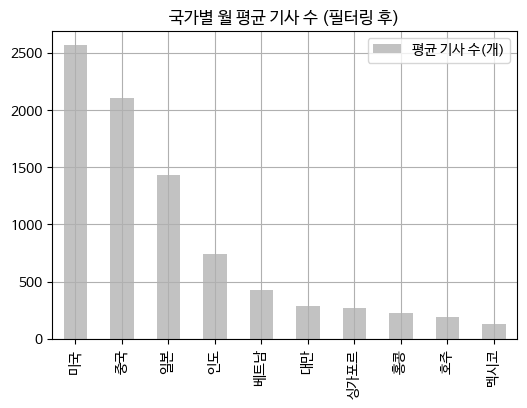

In [90]:
# 국가별 뉴스 개수
temps = []
for country in countries:
    temp = pd.read_csv(f"../DATA/news_count/NEWS_CNT_{country}.csv", index_col=0)
    temp.columns = [country]
    temps.append(temp)

mean_cnt = pd.concat(temps, axis=1).mean()
mean_cnt.index = country_names
mean_cnt = mean_cnt.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
mean_cnt.plot.bar(color="darkgray", label="평균 기사 수(개)", alpha=0.7)

ax.set_title('국가별 월 평균 기사 수 (필터링 후)')
ax.legend()
ax.grid(True)
plt.savefig('./output_3.2/국가별_월평균_기사 수(필터링 후).png', dpi=300)
plt.show()

### 4. 품목별 수출 증감 예측 모형 (뉴스데이터)

#### 품목별 키워드

In [18]:
# 품목 목록
print("HS4 Unique Count:", len(unique_hs4_top5))
print(unique_hs4_top5)

HS4 Unique Count: 17
['2710', '2902', '7106', '7208', '7210', '7308', '8473', '8486', '8517', '8529', '8534', '8542', '8703', '8708', '8901', '8905', '9013']


In [19]:
# 키워드 추가하기 위한 딕셔너리 포맷 출력
sample = {}
for k in sorted(unique_hs4_top5):
    sample[k] = []
print(sample)
# sample

{'2710': [], '2902': [], '7106': [], '7208': [], '7210': [], '7308': [], '8473': [], '8486': [], '8517': [], '8529': [], '8534': [], '8542': [], '8703': [], '8708': [], '8901': [], '8905': [], '9013': []}


In [6]:
# # 생성한 키워드
# 생성한 키워드
hs4_keywords = {
    '2710': ["원유", "가솔린", "경유", "항공유", "중질유"],
    '2902': ["벤젠", "나프탈렌", "톨루엔", "사이클로헥세인", "아닐린"],
    '7106': ["실버", "은괴", "은박", "은사"],
    '7208': ["철판", "강판", "코일", "압연강판", "압연 강판"],
    '7210': ["철판", "강판", "코일", "도금 강판", "도금강판"],
    '7308': ["레일", "강철 레일", "강철 교량", "교량", "강철 틀"],
    '8473': ["디램", "비디오 카드", "사운드 카드", "통신 모듈", "디램 모듈"],
    '8486': ["연마기", "웨이퍼", "도포기", "포토레지스트", "성형기"],
    '8517': ["스마트폰", "휴대전화", "모뎀", "전화기", "라우터"],
    '8529': ["안테나", "오디오 케이블", "라디오", "튜너", "스피커"],
    '8534': ["인쇄회로", "인쇄회로 기판", "회로", "PCB", "기판"],
    '8542': ["프로세서", "메모리", "IC", "그래픽", "GPU"],
    '8703': ["승용차", "자동차", "SUV", "EV", "트럭"],
    '8708': ["엔진", "변속기", "자동차 내장", "내장재", "자동차 부품"],
    '8901': ["컨테이너선", "유조선", "선박", "화물선", "벌크선"],
    '8905': ["시추선", "구조선", "소방선", "기중기선", "채굴 선박"],
    '9013': ["액정", "디스플레이", "패널", "LCD", "OLED"]
}
# pd.DataFrame(hs4_keywords)

#### 모형

In [22]:
# bow 로드
bows = {}
for hs4 in tqdm(unique_hs4_top5):
    # if not os.path.isfile(f"./bow/BOW_HS4-{hs4}.csv"):
    #     continue
    df = pd.read_csv(f"../DATA/bow/BOW_HS4-{hs4}.csv")
    df = df.set_index("ym")
    bows[hs4] = df

100%|██████████| 17/17 [02:32<00:00,  8.95s/it]


In [23]:
# bow_ratio 로 수정
bows_ratio = {}

for c, df in tqdm(bows.items()):
    df = df.fillna(0)
    
    ratios = []
    for ym in df.index:
        values = df.loc[ym, :].values
        ratio = (values / values.sum()) * 100
        ratios.append(ratio)

    bow_ratio = pd.DataFrame(ratios, index=df.index, columns=df.columns)
    bows_ratio[c] = bow_ratio

100%|██████████| 17/17 [01:04<00:00,  3.82s/it]


In [24]:
bows_ratio.keys()

dict_keys(['2710', '2902', '7106', '7208', '7210', '7308', '8473', '8486', '8517', '8529', '8534', '8542', '8703', '8708', '8901', '8905', '9013'])

In [25]:
# 기간샘플 시 test set 을 시작할 날짜
split_date = "202112"  # 23년만을 pred로 

# y_load
raw_df = pd.read_csv(f"../DATA/수출입_All.csv", low_memory=False)

# for hs4 in tqdm(unique_hs4_top5):
for hs4 in tqdm(bows_ratio.keys()):
    # 국가별 데이터 로드
    bow_ratio = bows_ratio[hs4]

    # y_get
    df = raw_df.copy()
    df = df.loc[df["HS코드"] != "-", :].copy()
    df["HS4"] = df["HS코드"].str[:4]
    df = df.loc[df["HS4"] == hs4, :].copy()
    
    exp = df.groupby("기간")["수출금액(달러)"].sum()
    exp = pd.DataFrame(exp)
    exp["yoy"] = exp["수출금액(달러)"].pct_change(12)
    exp["yoy_bin"] = exp["yoy"].dropna().apply(lambda x: 0 if x < 0 else 1)

    # processing for merge
    exp.index = exp.index.str.replace(".", "").astype(int)
    exp = exp.dropna().copy()
    exp["yoy_bin"] = exp["yoy_bin"].astype(int)

    # merge
    data = pd.merge(bow_ratio, exp[["yoy_bin"]], how="left", right_index=True, left_index=True)
    # data.iloc[[0, 1, -2, -1]]
    
    # 미래의 값을 예측해야 하므로, 위쪽으로 한칸씩 당김
    lag = -1
    
    # for lag in range(0, 6 + 1):
    # for lag in tqdm(range(1, 6 + 1)):
    # time lag
    target_data = data.copy()
    target_data["yoy_bin"] = target_data["yoy_bin"].shift(lag)
    target_data = target_data.dropna()
    target_data["yoy_bin"] = target_data["yoy_bin"].astype(int)
    # target_data.head(3)

    X = target_data.drop("yoy_bin", axis=1)
    y = target_data["yoy_bin"]

    # 훈련, 평가 시 사용할
    X_run = X.loc[:split_date].iloc[:-1]
    y_run = y.loc[:split_date].iloc[:-1]

    # predict 만들 때 사용할
    X_predict = X.loc[split_date:]  # split_date부터 끝까지 포함 (12월부터 포함하는 이유는 12월 예측값이 lag이 1이므로 1월의 값을 예측한 것이 됨)
    y_predict = y.loc[split_date:]

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_run, y_run, test_size=0.2, random_state=0)

    # model fit
    # model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    vc = y_test.value_counts()
    if len(vc.index) == 2:  # 0과 1 모두 y에 존재하는 경우
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:  # else: ROC_AUC 계산 불가함
        auc = None

    # table_row
    rows = []
    row = {}
    row["HS4"] = hs4
    row["Lag"] = lag
    row["N-Train"] = len(X_train)
    row["N-Test"] = len(X_test)
    row["True Ratio"] = y_test.mean()
    row["Accuracy"] = acc
    row["ROC_AUC Score"] = auc
    rows.append(row)

    if len(X_predict.dropna()) == 0:
        print("데이터가 부족함(for Predict):", country, code, len(data))
        continue

    # 예측값도 저장 (추론모형에 포함)
    model_pred = pd.DataFrame(y_predict)
    model_pred.columns = ["True"]
    model_pred["Predict"] = model.predict(X_predict)
    model_pred["Proba"] = model.predict_proba(X_predict)[:, 1]
    model_pred.to_csv(f"./output_3.2/품목별모형_데이터/Predict_{hs4}.csv")

    result_df = pd.DataFrame(rows)
    result_df.to_csv(f"./output_3.2/품목별모형_데이터/df_Result_{hs4}.csv", index=False)

100%|██████████| 17/17 [01:11<00:00,  4.22s/it]


In [26]:
X_predict

,것,기사,이,등,미국,수출,수,뉴스,주가,전자신문,...,브라마,난후,감비아,올블랙,버킹엄,버킹엄궁,차퀘,전자지갑,랜섬,룸들
ym,,,,,,,,,,,,,,,,,,,,,
202112,1.042535,0.039062,0.425347,1.753472,0.240451,2.140625,0.509549,0.059896,0.065972,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202201,1.261608,0.039716,0.462224,1.770308,0.557710,1.706087,0.552640,0.072671,0.060841,0.000845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202202,0.989924,0.032746,0.455919,1.327456,0.680101,1.005038,0.574307,0.044081,0.062972,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202203,0.924307,0.039402,0.394021,1.824809,0.384170,1.412729,0.494168,0.059103,0.039402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202204,1.169326,0.042301,0.463299,1.468455,0.404883,1.313351,0.559987,0.069495,0.048344,0.002014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202205,0.994120,0.041079,0.537552,1.564536,0.484736,1.044589,0.624406,0.075116,0.073943,0.002347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202206,1.096678,0.031660,0.415981,1.450219,0.391357,0.853949,0.636724,0.065080,0.074754,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202207,1.106064,0.025881,0.632717,1.530372,0.294905,1.035913,0.475389,0.077642,0.083091,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202208,0.916504,0.032158,0.530608,1.559665,0.624210,1.546457,0.536924,0.053980,0.052831,0.001149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 그래프

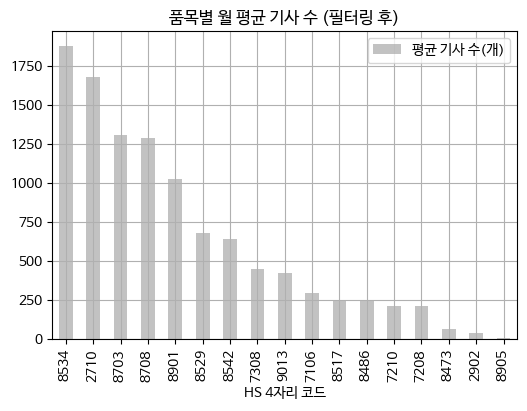

In [91]:
# 품목별 뉴스 개수
temps = []
for hs4 in unique_hs4_top5:
    temp = pd.read_csv(f"../DATA/news_count/NEWS_CNT_{hs4}.csv", index_col=0)
    temp.columns = [hs4]
    temps.append(temp)

mean_cnt = pd.concat(temps, axis=1).mean()
# mean_cnt.index = country_names
mean_cnt = mean_cnt.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,4))
mean_cnt.plot.bar(color="darkgray", label="평균 기사 수(개)", alpha=0.7)

ax.set_title('품목별 월 평균 기사 수 (필터링 후)')
ax.legend()
ax.set_xlabel('HS 4자리 코드')
ax.grid(True)
plt.savefig('./output_3.2/품목별_월평균_기사 수(필터링 후).png', dpi=300)
plt.show()